# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\pc\AppData\Local\Temp\ipykernel_4860\3444345040.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Chargement des données d'apprentissage et de test

In [2]:
# Chargement des données d'apprentissage
DataFeatureApp=np.load('./DataApp.npy') #features
LabelApp=np.load('./LabelApp.npy')    #target
print('Taille de la base d apprentissage :', DataFeatureApp.shape, LabelApp.shape)

# Chargement des données de test
DataFeatureTest=np.load('./DataTest.npy')
LabelTest=np.load('./LabelTest.npy')
print('Taille de la base d apprentissage :', DataFeatureTest.shape, LabelTest.shape)

print('Les classes sont :', np.unique(LabelApp))
print('Les classes sont :', np.unique(LabelTest))



Taille de la base d apprentissage : (5000, 156) (5000,)
Taille de la base d apprentissage : (750, 156) (750,)
Les classes sont : [0. 1. 2. 3. 4.]
Les classes sont : [0. 1. 2. 3. 4.]


# Chargement des variables issues *TSFEL*

Nombre de variables statistiques : (31,)


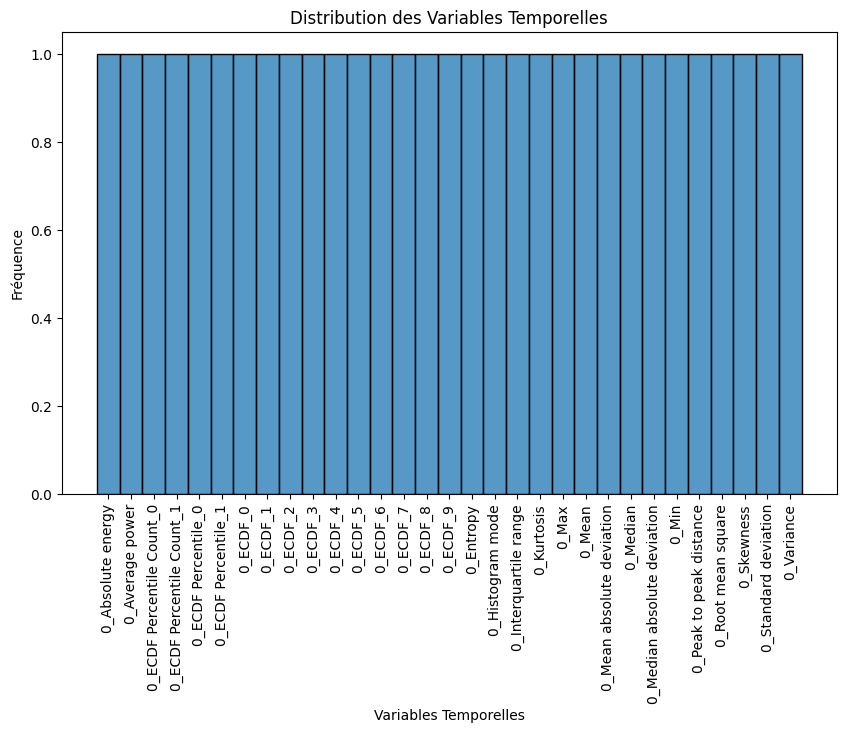

Nombre de variables temporelles : (14,)


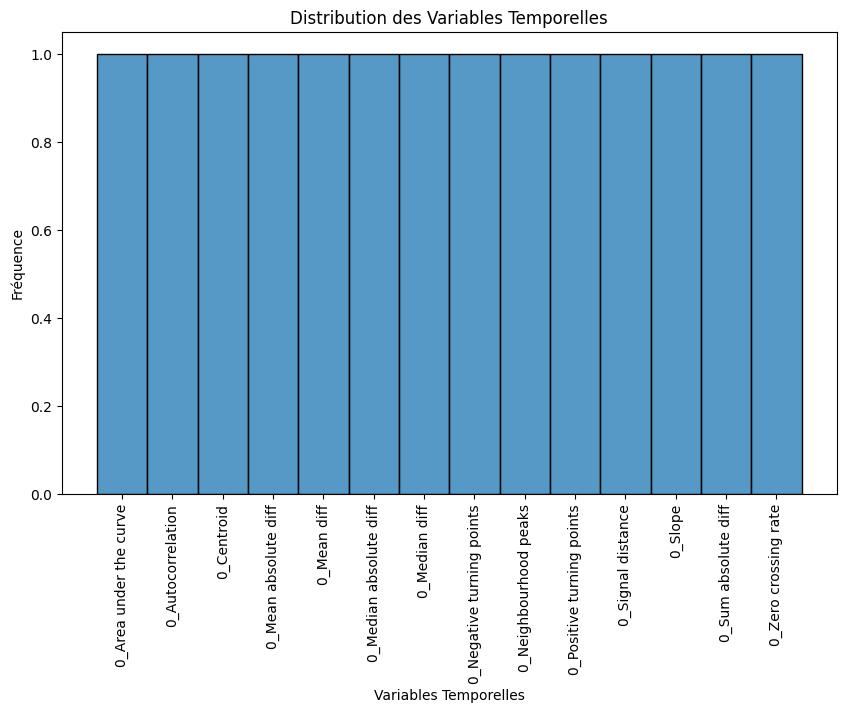

Nombre de variables spectrales : (111,)


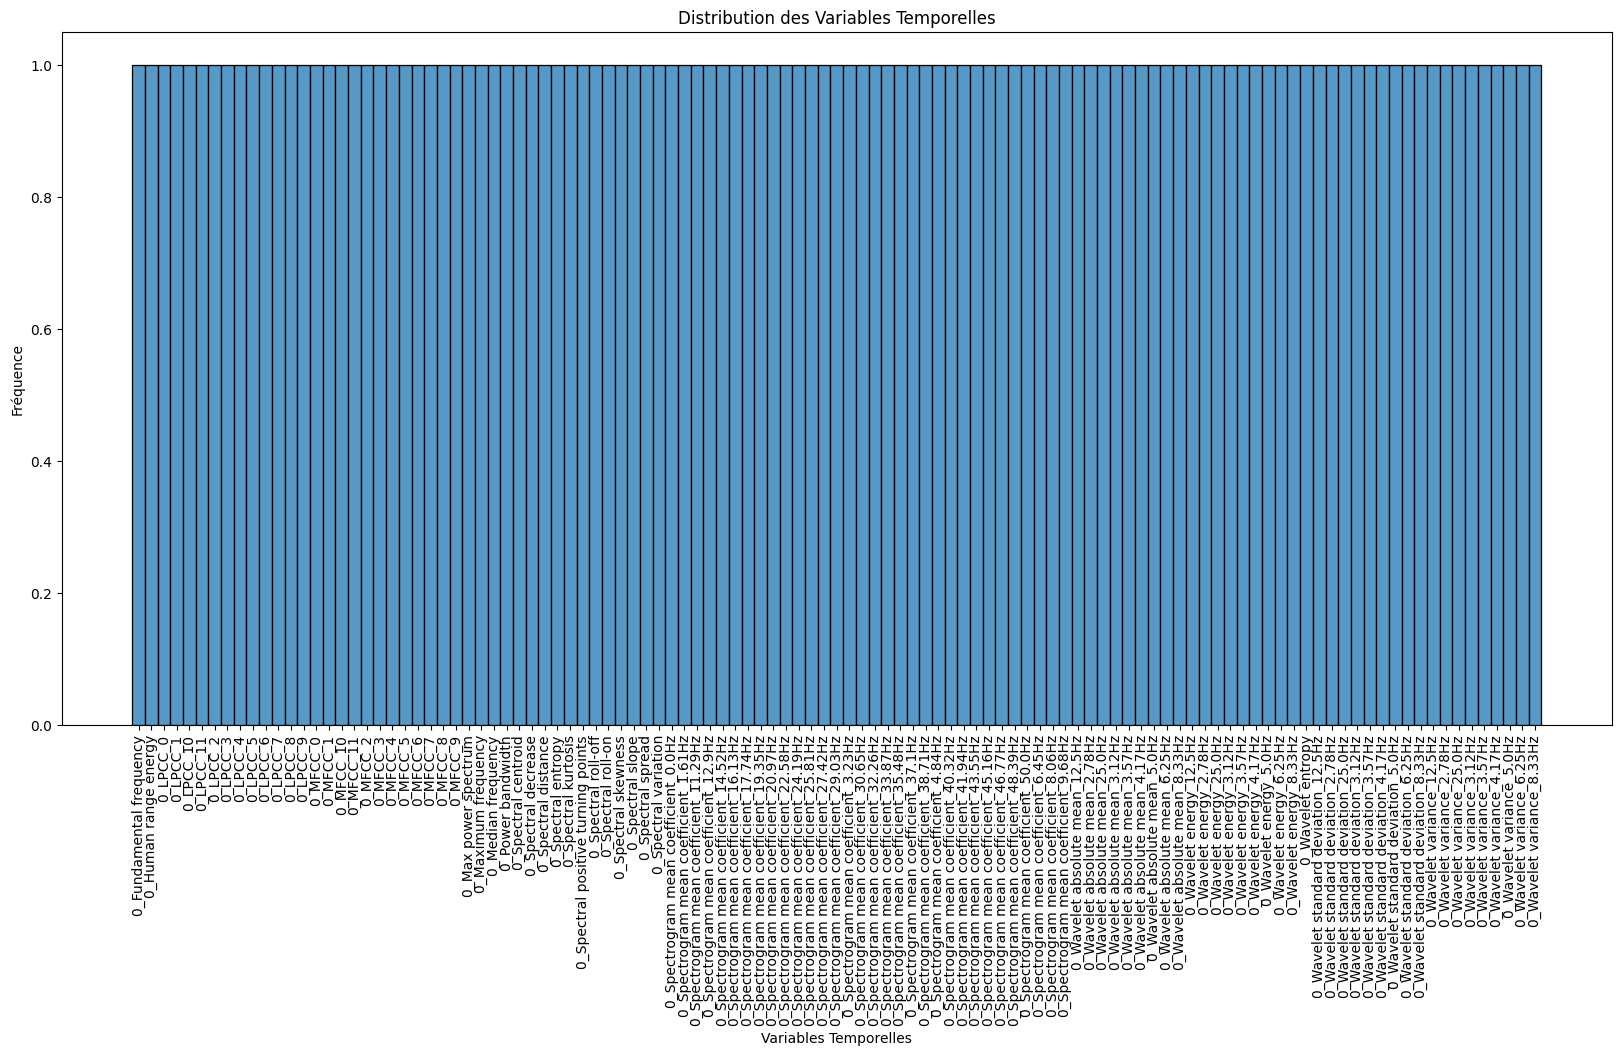

In [11]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)
plt.figure(figsize=(10, 6))
sns.histplot(ListeVariablesStat, kde=False)
plt.title('Distribution des Variables Temporelles')
plt.xlabel('Variables Temporelles')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.show()
ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)
plt.figure(figsize=(10, 6))
sns.histplot(ListeVariablesTemps, kde=False)
plt.title('Distribution des Variables Temporelles')
plt.xlabel('Variables Temporelles')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.show()

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)
plt.figure(figsize=(20, 9))
sns.histplot(ListeVariablesSpectral, kde=False)
plt.title('Distribution des Variables Temporelles')
plt.xlabel('Variables Temporelles')
plt.ylabel('Fréquence')
plt.xticks(rotation=90)
plt.show()


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.
# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index == 1].astype(int)).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels




# Partie I : Classification des battements cardiaques sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

Le taux de précision pour la Gaussian naive bayes est : 66.4 %


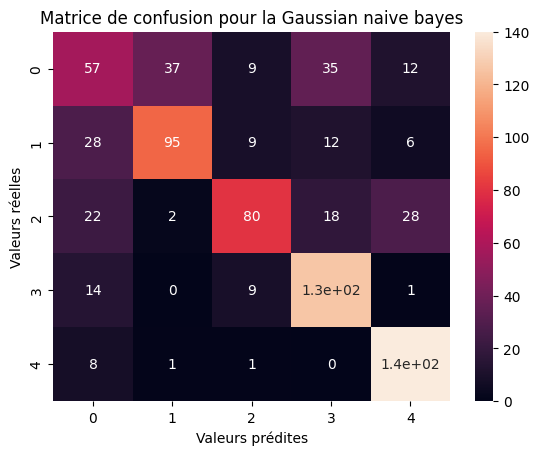

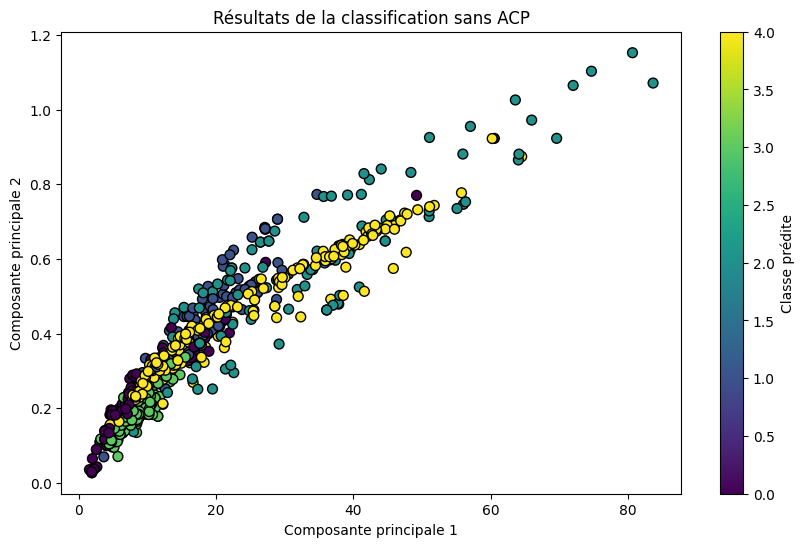

Le taux de précision pour l arbre de decision est : 80.26666666666667 %


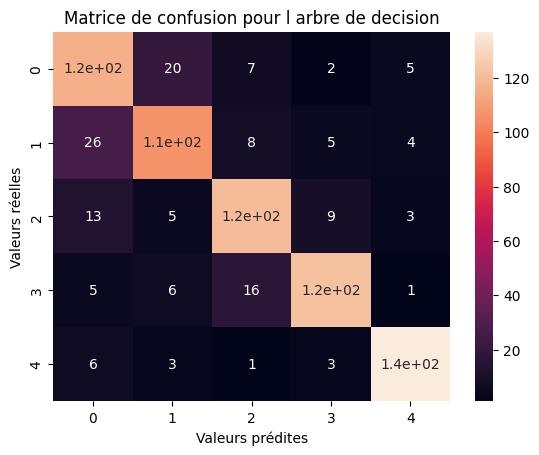

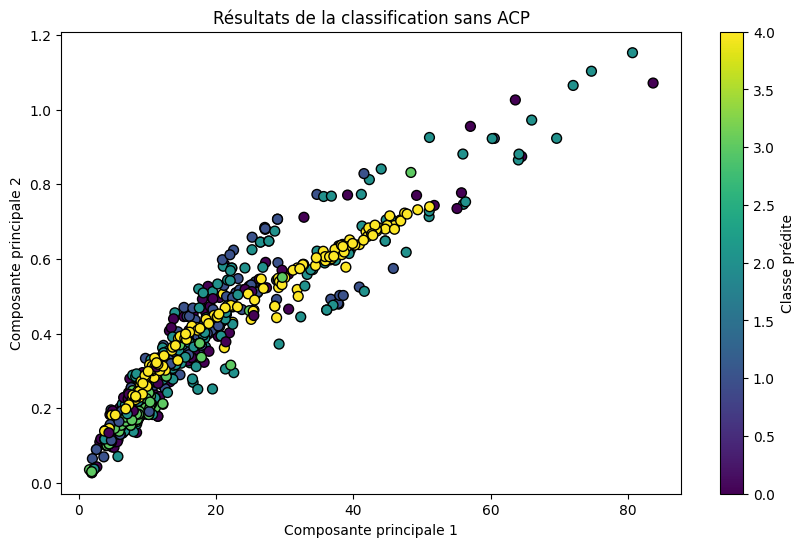

In [5]:
# dans cette partie on a l'aider d'utuliser la regression logistique et arbre de decision pour comparer les resultats obtenus avec les methode non superviser
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


X_train=DataFeatureApp
y_train=LabelApp
X_test=DataFeatureTest
y_test=LabelTest

# Gaussian Naive Bayes
Gauss=GaussianNB(priors=None, var_smoothing=1e-7)
Gauss.fit(X_train,y_train)
y_pred=Gauss.predict(X_test)
#calculer la matrice de confusion
confusion_matrix(y_test,y_pred)
#calculer le taux de precision
acuray_score=accuracy_score(y_test,y_pred)
print('Le taux de précision pour la Gaussian naive bayes est :',acuray_score*100,"%")
plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.title('Matrice de confusion pour la Gaussian naive bayes') 
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

# Affichage des résultats graphiquement en x et y
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Résultats de la classification sans ACP')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Classe prédite')
plt.show()
# Arbre de decision
tree=DecisionTreeClassifier(random_state=0)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)
#calculer la matrice de confusion
confusion_matrix(y_test,y_pred)
#calculer le taux de precision
acuray_score=accuracy_score(y_test,y_pred)
print('Le taux de précision pour l arbre de decision est :',acuray_score*100,"%")
plt.figure()
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.title('Matrice de confusion pour l arbre de decision')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()
#confusion_matrix(y_true, y_pred)

# Affichage des résultats graphiquement en x et y
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Résultats de la classification sans ACP')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Classe prédite')
plt.show()



## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.

y_pred_Kmeans [0 1 2 3 4]
y_pred with function correspondace [0. 1. 2. 3. 4.]
True data [0. 1. 2. 3. 4.]
Le taux de précision pour la méthode non supervisée est : 39.6 %
[[229 311  98 439  73]
 [150 469 181 291  59]
 [ 16 335 424 124 251]
 [100 318  31 693   8]
 [ 59 175 154 300 462]]


C:\Users\pc\AppData\Local\Temp\ipykernel_4860\751103171.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


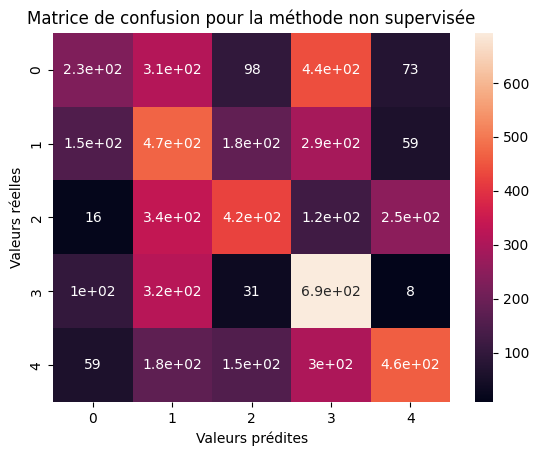

In [6]:

from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=5, random_state=0)

y_train = np.concatenate((LabelApp, LabelTest))
data_all = np.vstack((DataFeatureApp, DataFeatureTest))
y_pred_kmeans = k_means.fit_predict(data_all)
print("y_pred_Kmeans",np.unique(y_pred_kmeans))
y_pred = correspondance(y_pred_kmeans, y_train) # les classes prédites pour la methodes non superviser 
print("y_pred with function correspondace",np.unique(y_pred))
print("True data",np.unique(y_train)) 

acuray_score=accuracy_score(y_train, y_pred)
print('Le taux de précision pour la méthode non supervisée est :',acuray_score*100,"%")

matrice_confusion=confusion_matrix(y_train, y_pred)
print(matrice_confusion)
plt.figure()
sns.heatmap(matrice_confusion, annot=True)
plt.title('Matrice de confusion pour la méthode non supervisée')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()




[0. 0. 0. ... 4. 4. 4.]


C:\Users\pc\AppData\Local\Temp\ipykernel_4860\751103171.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


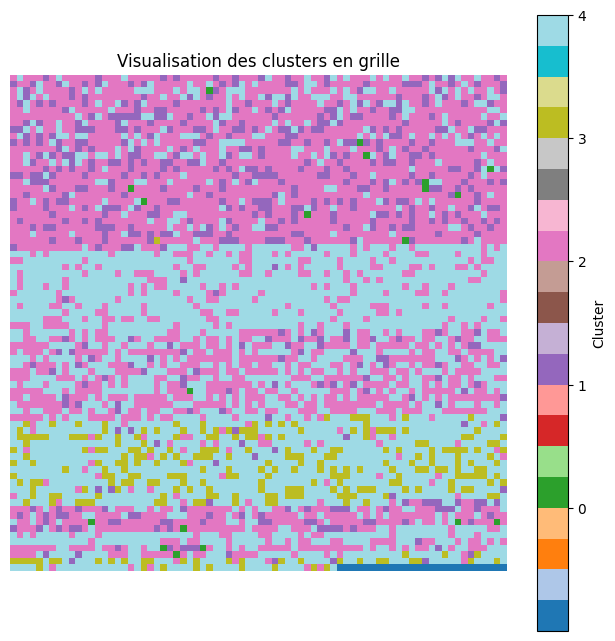

Le taux de précision pour la méthode non supervisée est : 38.81739130434782 %


In [44]:
#Classification Ascendant Hiérarchies

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import LabelEncoder

y_train = np.concatenate((LabelApp, LabelTest))
data_all = np.vstack((DataFeatureApp, DataFeatureTest))

# 1. Calcul des distances entre les points
distances = pdist(data_all, metric='cosine')

# 2. Application de la méthode de fusion ascendante
Z = sch.linkage(distances, method='ward')

num_clusters = 5
clusters = fcluster(Z, num_clusters, criterion='maxclust')

label_encoder = LabelEncoder()
cluster_labels = label_encoder.fit_transform(clusters)  # Convert clusters to color indices

# Dimensions pour la grille (carré ou presque carré)
num_points = len(clusters)
grid_size = int(np.ceil(np.sqrt(num_points)))  # Dimensions de la grille

# Créer une matrice carrée remplie de -1 (pour les cases vides, si nécessaire)
grid = -np.ones((grid_size, grid_size))
grid.flat[:num_points] = cluster_labels  # Remplir les premières cases avec les labels

print(y_train)

y_pred = correspondance(cluster_labels,y_train) # les classes prédites pour la methodes non superviser 
# 5. Visualisation de la matrice de clusters avec un colormap
plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='tab20', aspect='equal')  # Choix du colormap `tab20` pour des couleurs distinctes
plt.colorbar(ticks=range(num_clusters), label="Cluster")
plt.title("Visualisation des clusters en grille")
plt.axis('off')  # Masquer les axes
plt.show()



accuracy = accuracy_score(y_train, y_pred)
print('Le taux de précision pour la méthode non supervisée est :',accuracy*100,"%")

# Partie II : classification des battements cardiaques avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

Exactitude du modèle après ACP : 56.39999999999999


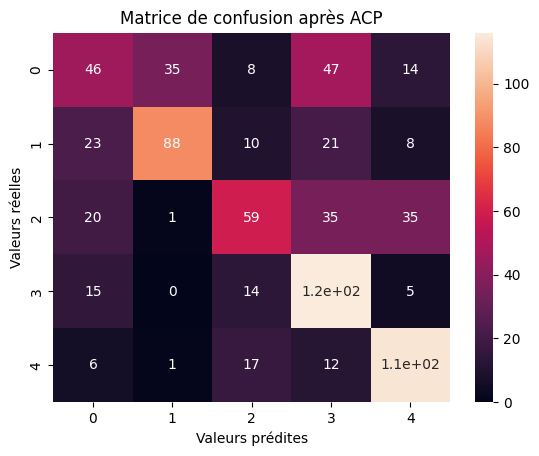

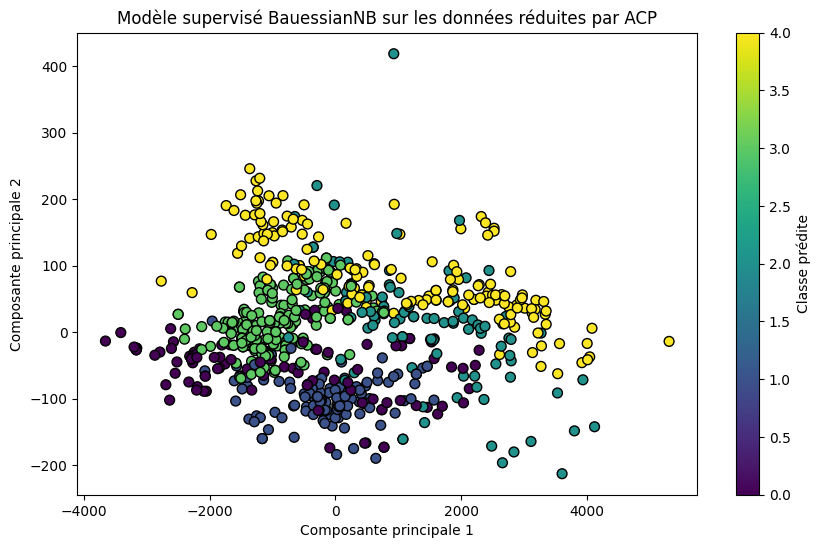

Exactitude du modèle après ACP : 66.4


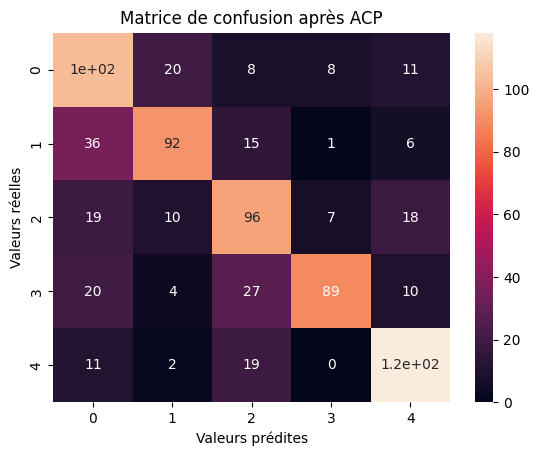

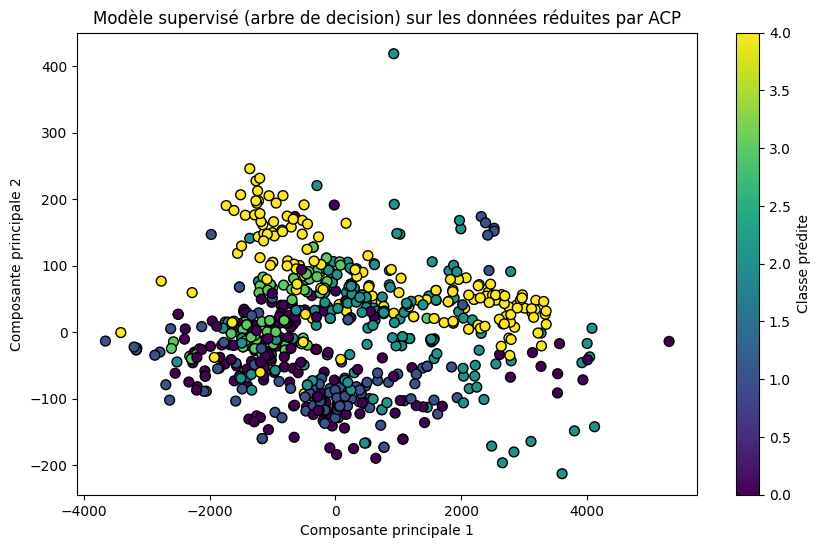

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score 

# Combiner les données d'apprentissage et de test
DataFeature = np.vstack((DataFeatureApp, DataFeatureTest))
# Réduction de dimension avec ACP
pca = PCA(n_components=4)
pca.fit(DataFeature)
X_train = pca.transform(DataFeatureApp)
X_test = pca.transform(DataFeatureTest)

# Utiliser les mêmes échantillons pour y_train et X_train
y_train = LabelApp
y_test = LabelTest

# Modèle supervisé (régression logistique) sur les données réduites par ACP
model = GaussianNB(priors=None, var_smoothing=1e-7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle après ACP :", accuracy*100)

# Matrice de confusion
confusion = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(confusion, annot=True)
plt.title('Matrice de confusion après ACP')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Modèle supervisé BauessianNB sur les données réduites par ACP')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Classe prédite')
plt.show()

# Modèle supervisé (arbre de decision) sur les données réduites par ACP
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle après ACP :", accuracy*100)
# Matrice de confusion
confusion = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(confusion, annot=True)
plt.title('Matrice de confusion après ACP')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

# Affichage des résultats graphiquement en x et y
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Modèle supervisé (arbre de decision) sur les données réduites par ACP')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Classe prédite')
plt.show()


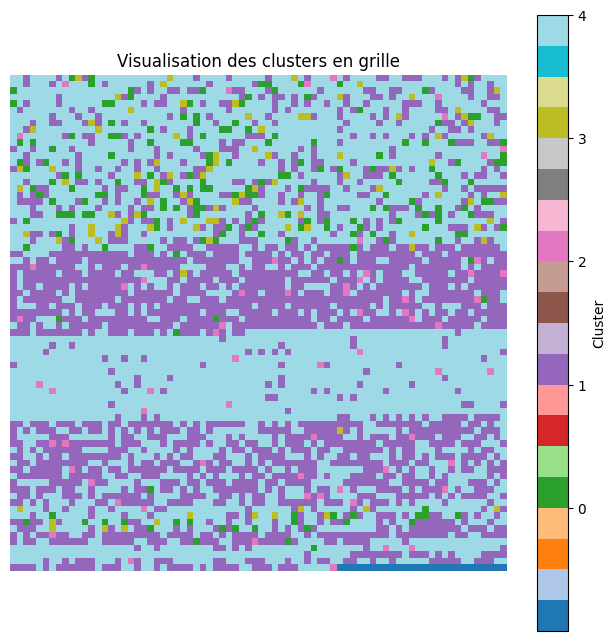

Le taux de précision pour la méthode de classification hiérarchique ascendante est : 36.99130434782609 %


In [ ]:
# Calcul de la matrice de confusion


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

y_pred_Kmeans [0 1 2 3 4]
y_pred with function correspondace [0. 1. 2. 3. 4.]
True data [0. 1. 2. 3. 4.]
Le taux de précision pour la méthode non supervisée est : 39.6 %
[[230 307  98 442  73]
 [158 462 180 291  59]
 [ 16 340 416 127 251]
 [100 304  31 707   8]
 [ 60 174 154 300 462]]


C:\Users\pc\AppData\Local\Temp\ipykernel_4860\751103171.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


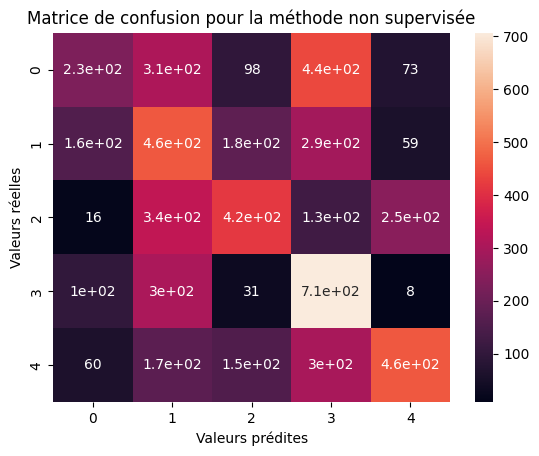

In [8]:
pca = PCA(n_components=2)
y_train = np.concatenate((LabelApp, LabelTest))
data_all = np.vstack((X_train, X_test))
pca.fit(data_all)
data_all = pca.transform(data_all)
k_means = KMeans(n_clusters=5, random_state=0)
y_pred_kmeans = k_means.fit_predict(data_all)
print("y_pred_Kmeans",np.unique(y_pred_kmeans))
y_pred = correspondance(y_pred_kmeans,y_train) # les classes prédites pour la methodes non superviser 
print("y_pred with function correspondace",np.unique(y_pred))
print("True data",np.unique(y_train)) 

acuray_score=accuracy_score(y_train,y_pred)
print('Le taux de précision pour la méthode non supervisée est :',acuray_score*100,"%")

matrice_confusion=confusion_matrix(y_train,y_pred)
print(matrice_confusion)
plt.figure()
sns.heatmap(matrice_confusion,annot=True)
plt.title('Matrice de confusion pour la méthode non supervisée')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()



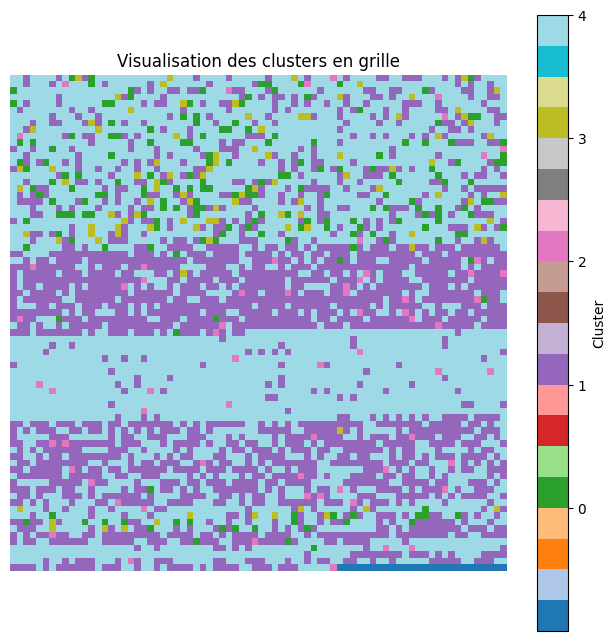

Le taux de précision pour la méthode de classification hiérarchique ascendante est : 36.99130434782609 %


In [46]:
# Réduction de dimensions avec PCA
pca = PCA(n_components=4)
y_train = np.concatenate((LabelApp, LabelTest))
data_all = np.vstack((DataFeatureApp, DataFeatureTest))
X_train = pca.fit_transform(data_all)

# Calcul des distances et linkage
distances = pdist(X_train, metric='cosine')
Z = sch.linkage(distances, method='ward')

# Classification hiérarchique
num_clusters = 5
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# Encoder les labels des clusters
label_encoder = LabelEncoder()
cluster_labels = label_encoder.fit_transform(clusters)

# Ajuster la taille si nécessaire
if len(cluster_labels) != len(y_train):
    min_size = min(len(cluster_labels), len(y_train))
    cluster_labels = cluster_labels[:min_size]
    y_train = y_train[:min_size]

# Correspondance entre les clusters et les étiquettes réelles
reference_labels = {}
for i in np.unique(cluster_labels):
    indices = np.where(cluster_labels == i)[0]
    if len(indices) > 0:
        num = np.bincount(y_train[indices].astype(int)).argmax()
        reference_labels[i] = num

# Traduire les prédictions des clusters en étiquettes correspondantes
y_pred = np.array([reference_labels[label] for label in cluster_labels])

# Visualisation des clusters en grille
num_points = len(cluster_labels)
grid_size = int(np.ceil(np.sqrt(num_points)))
grid = -np.ones((grid_size, grid_size))
grid.flat[:num_points] = cluster_labels

plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='tab20', aspect='equal')
plt.colorbar(ticks=range(num_clusters), label="Cluster")
plt.title("Visualisation des clusters en grille")
plt.axis('off')
plt.show()

# Calcul de la précision
accuracy = accuracy_score(y_train, y_pred)
print('Le taux de précision pour la méthode de classification hiérarchique ascendante est :', accuracy * 100, "%")

In [ ]:
# Calcul de la matrice de confusion



# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP


Taille des données statistiques : (5750, 31)
Taille des données temporelles : (5750, 14)
Taille des données spectrales : (5750, 111)


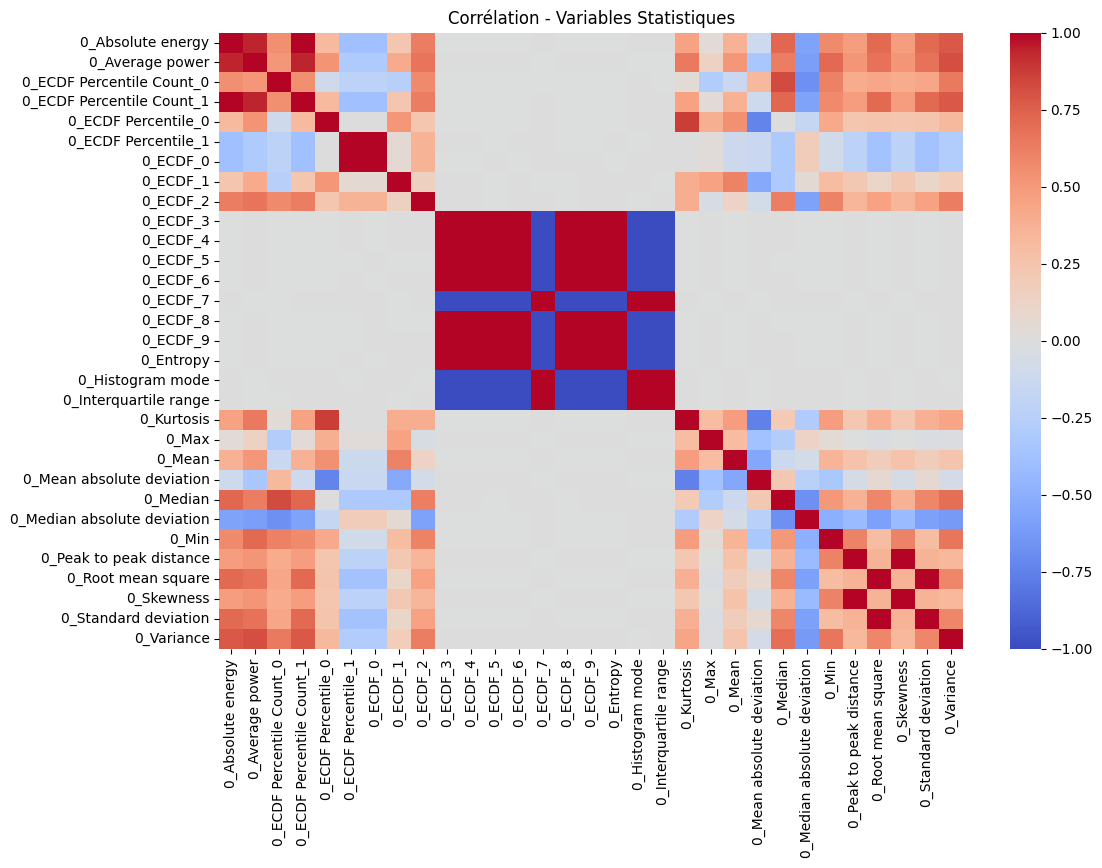

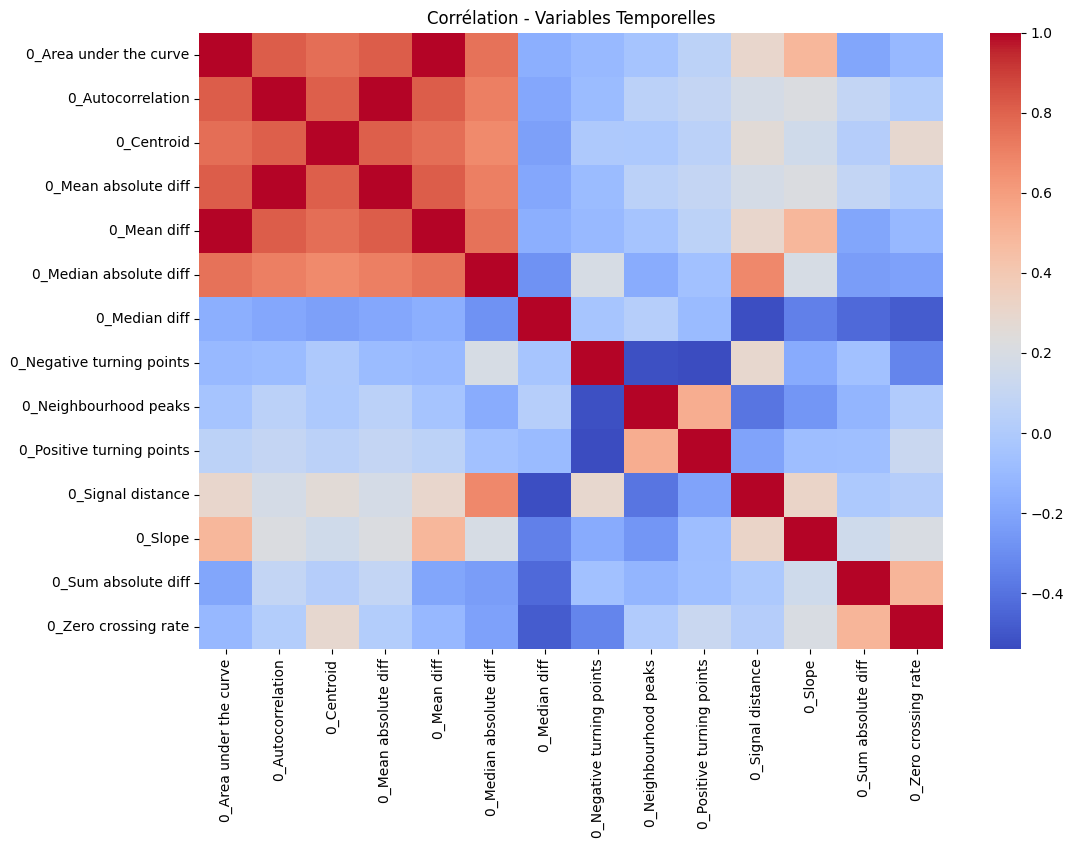

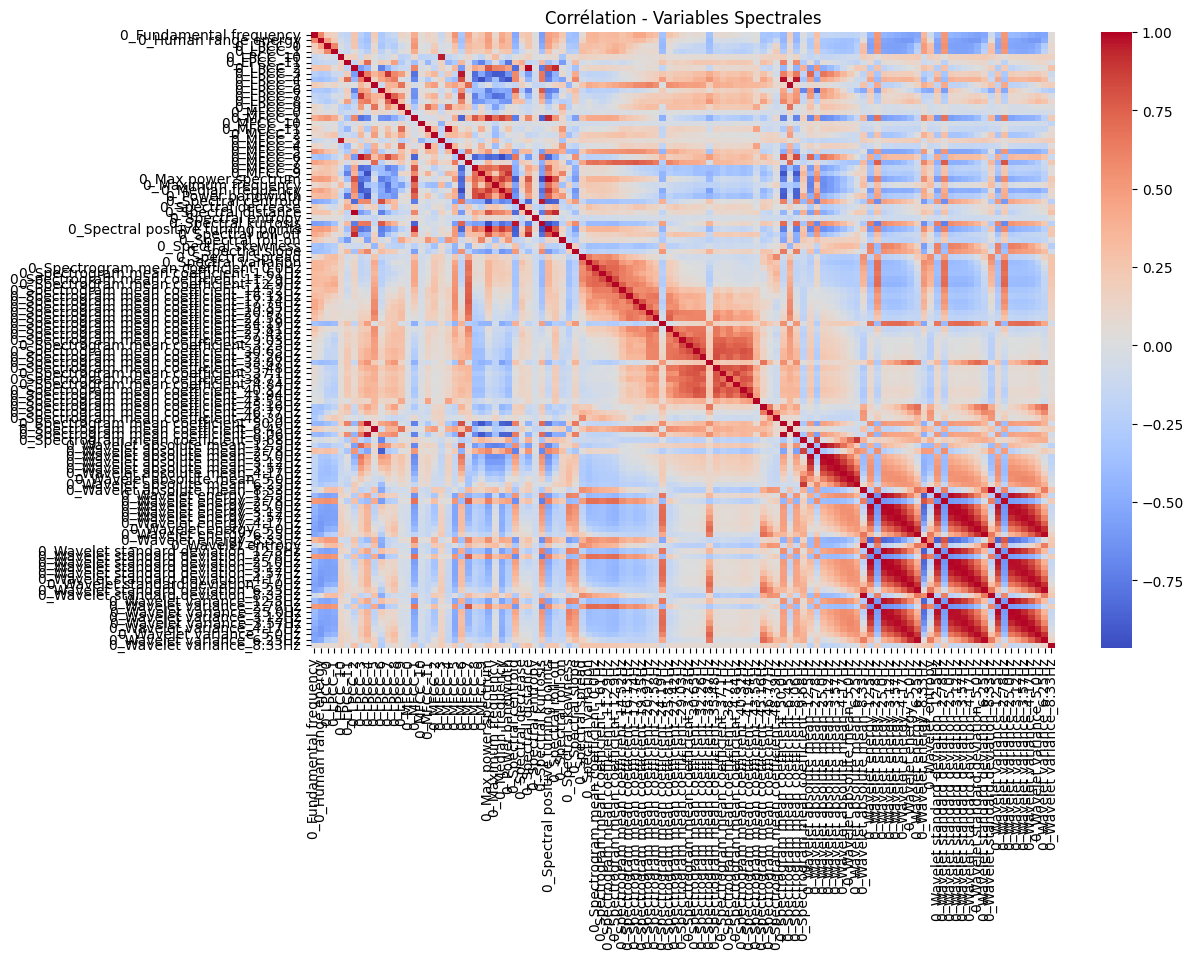

Variables supprimées (statistiques) : 0
Variables supprimées (temporelles) : 0
Variables supprimées (spectrales) : 0


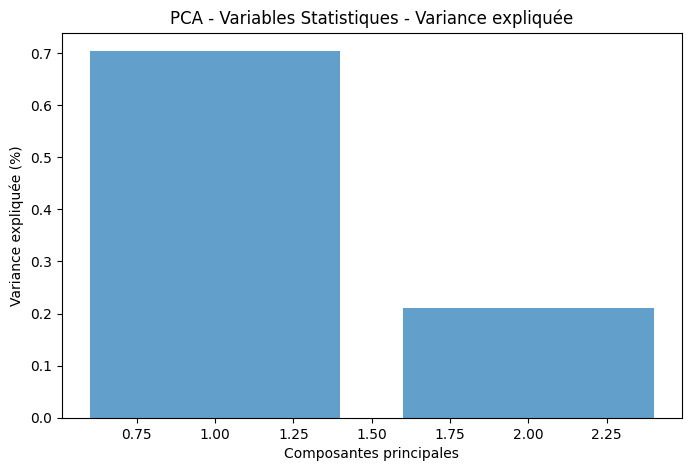

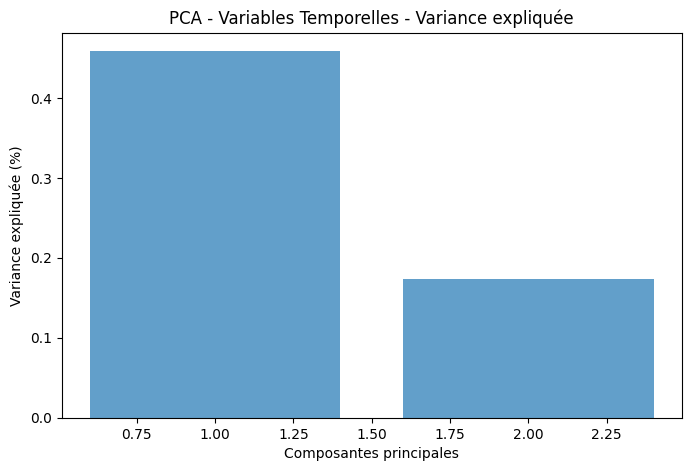

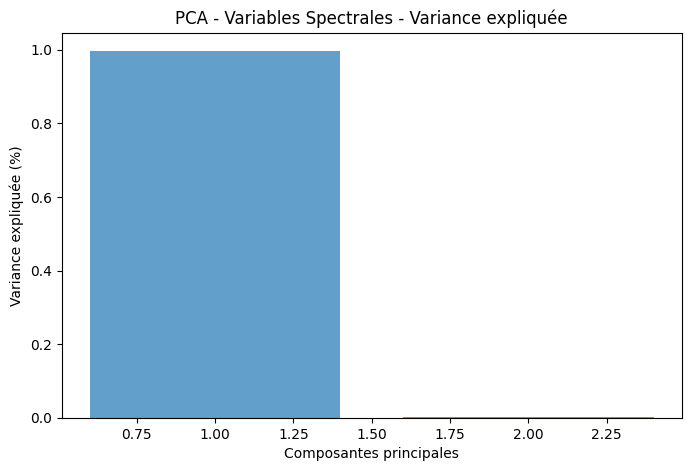

C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1635652429.py:104: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(column, label=var_names[i])
C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1635652429.py:104: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(column, label=var_names[i])
C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1635652429.py:104: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(column, label=var_names[i])
C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1635652429.py:104: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(column, label=var_names[i])
C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1635652429.py:104: UserWarning: Dataset has 0 variance; skippi

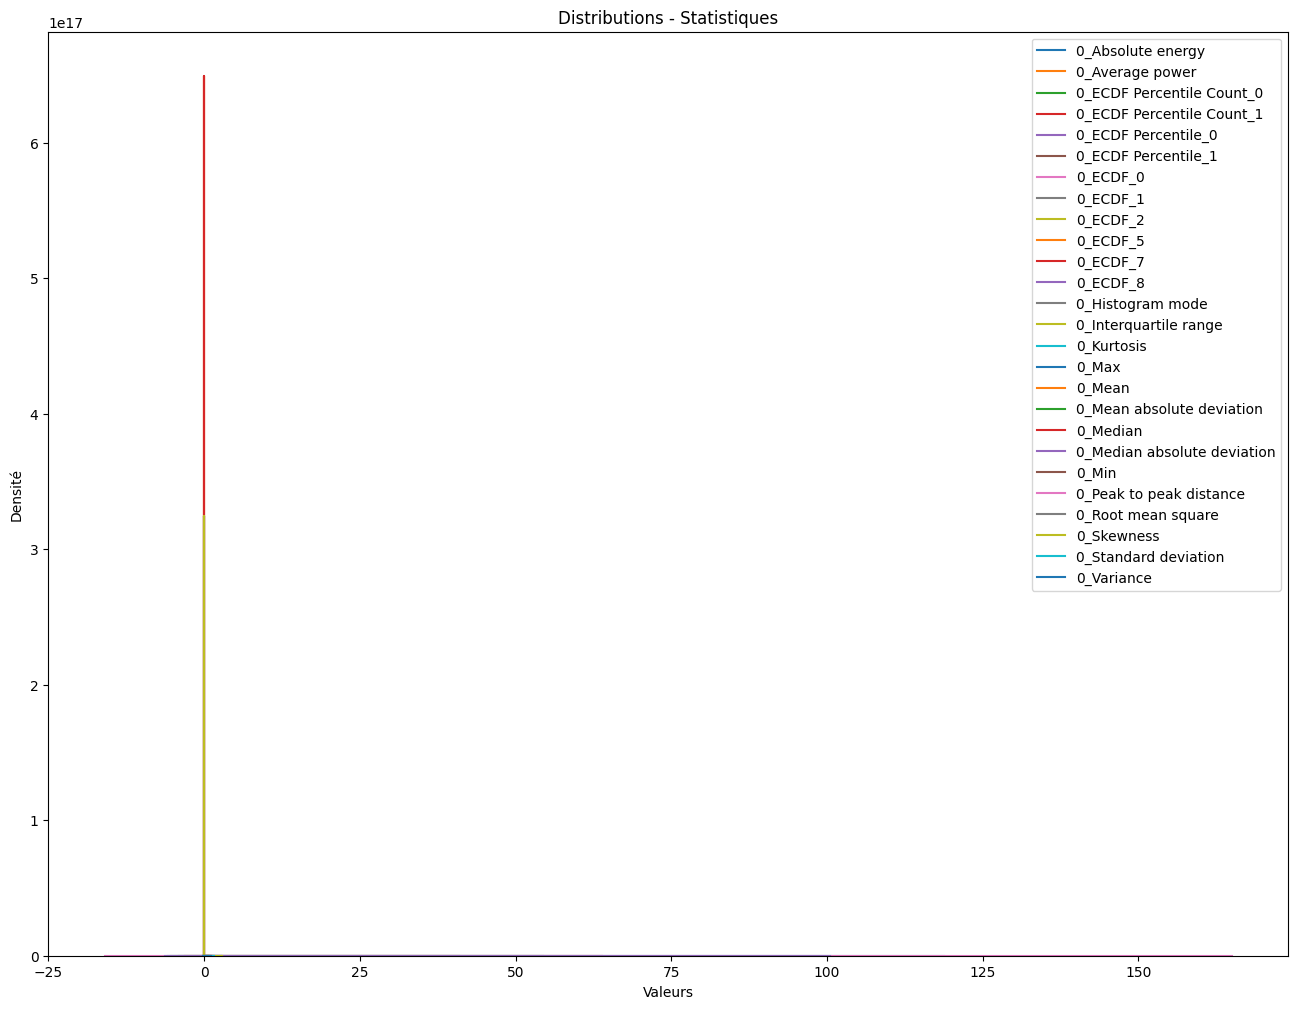

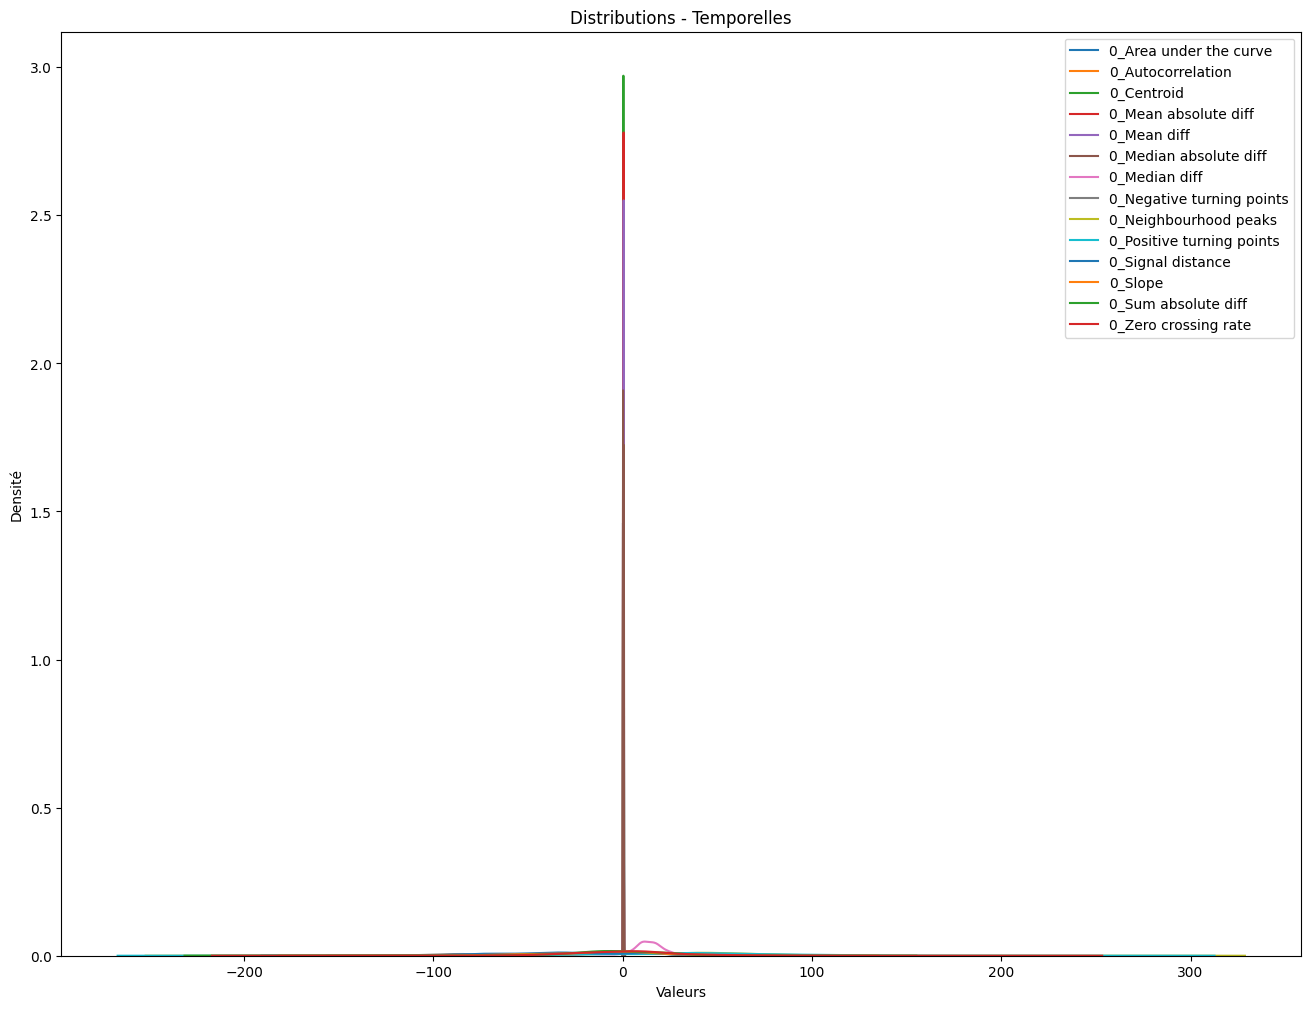

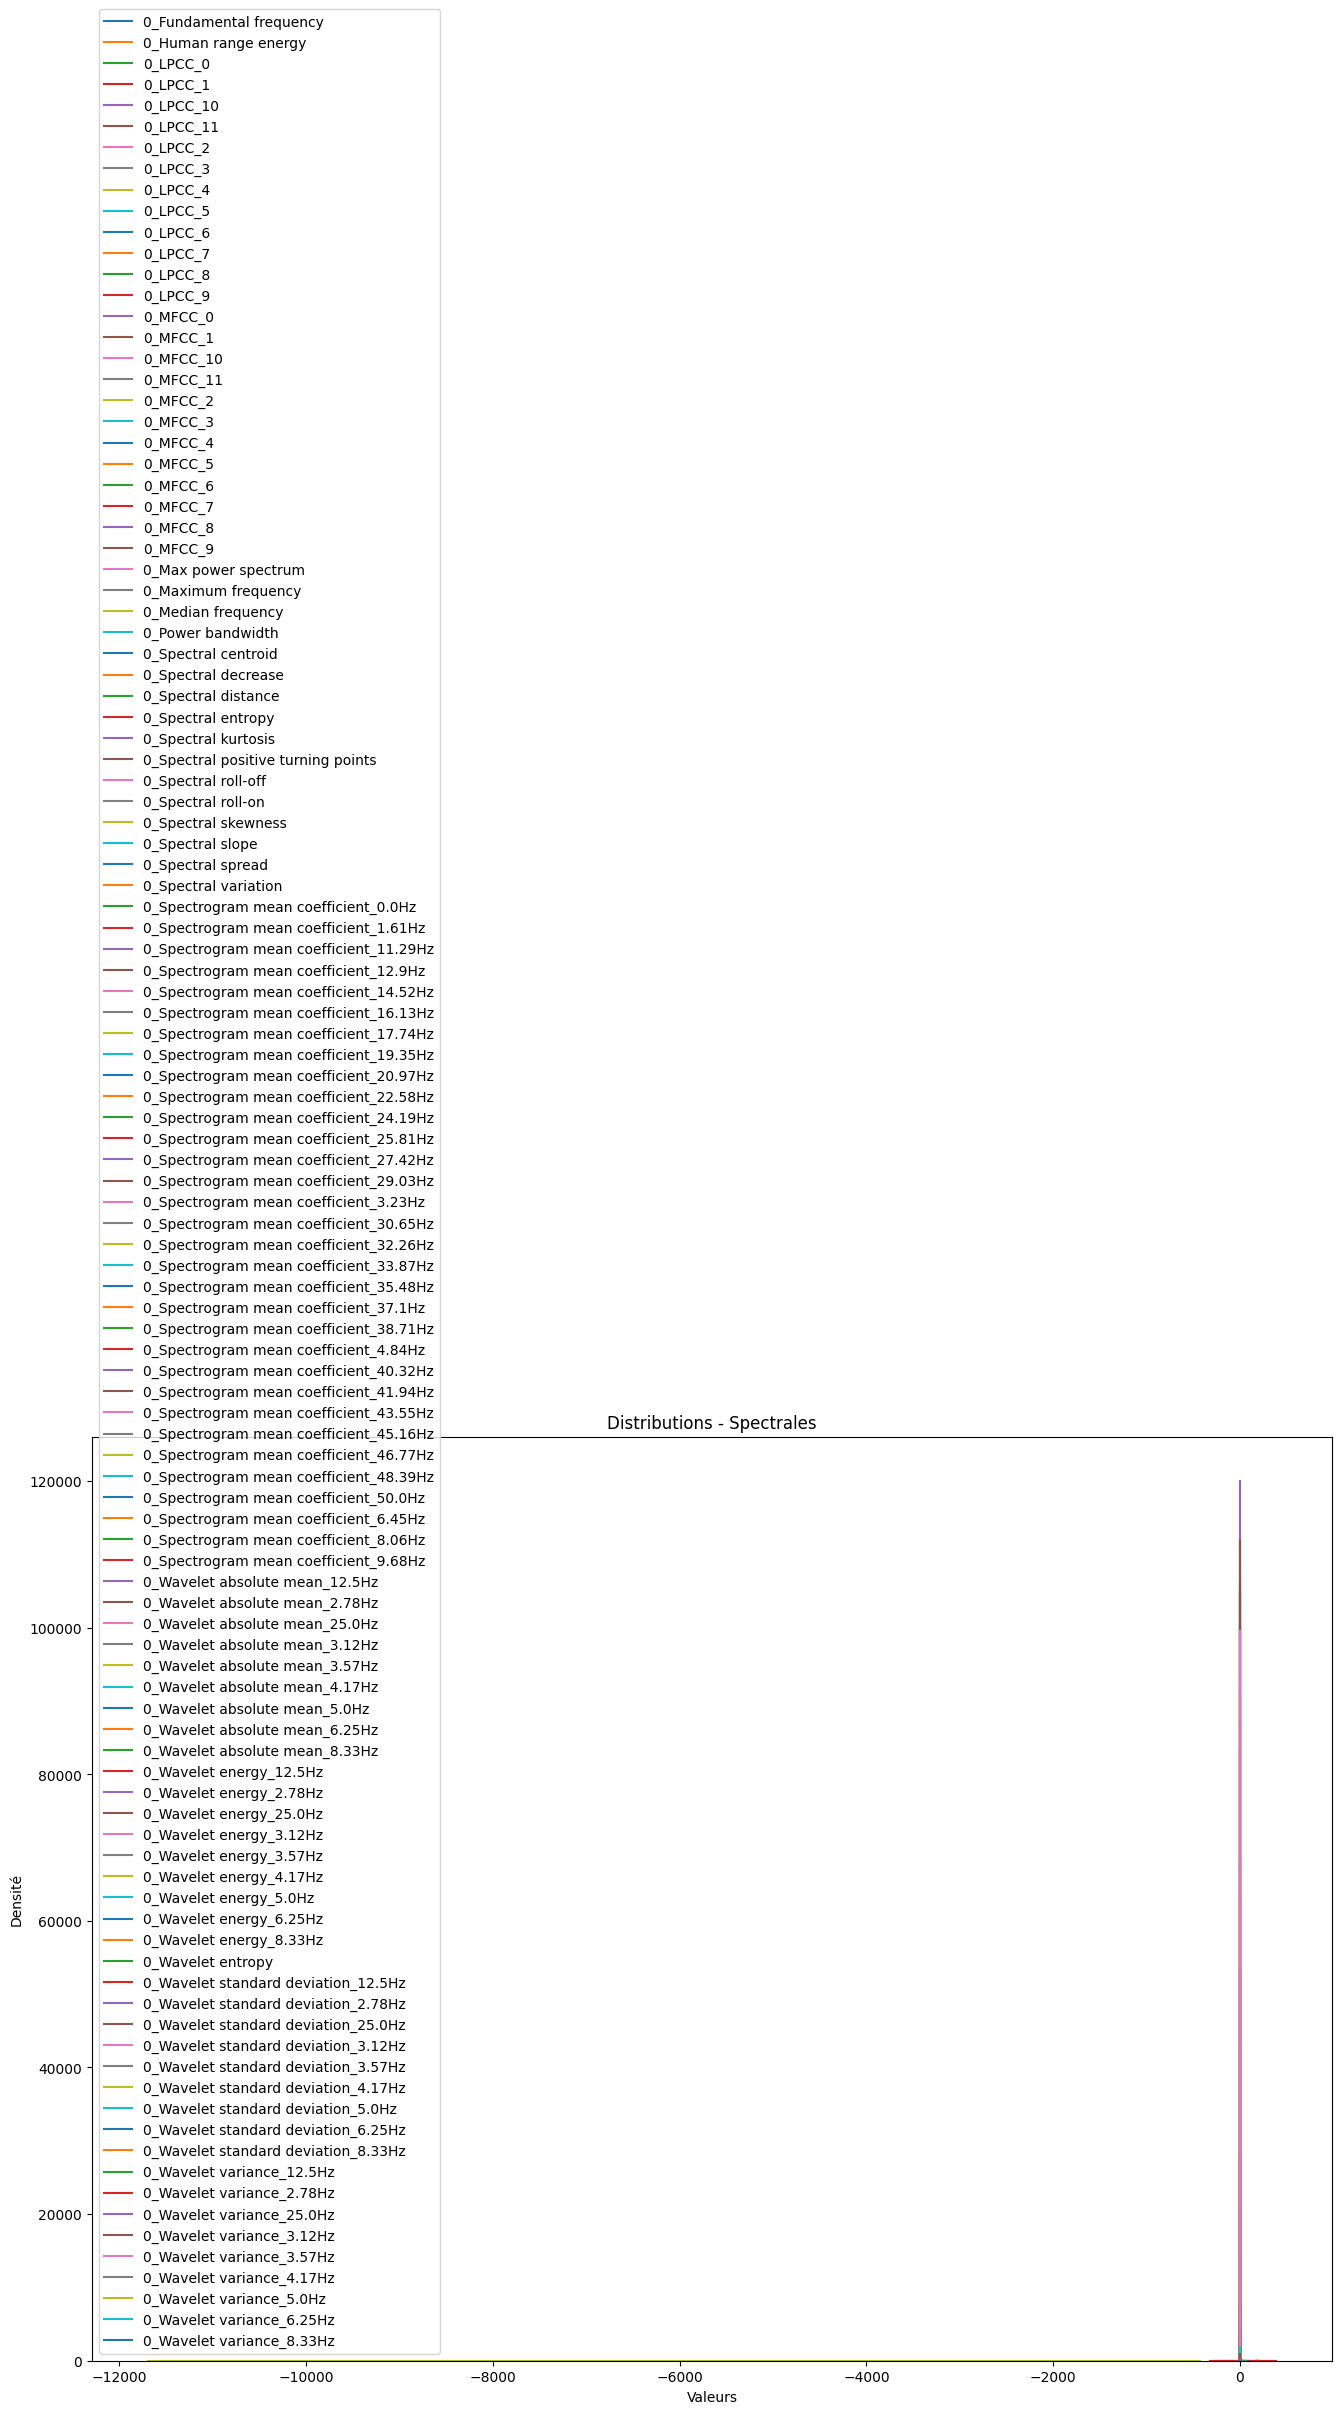

Résumé des données après prétraitement :
Statistiques : (5750, 31)
Temporelles : (5750, 14)
Spectrales : (5750, 111)


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# **1. Vérification des données et séparation en modalités**
DataFeature = np.vstack((DataFeatureApp, DataFeatureTest))
LabelsCombined = np.hstack((LabelApp, LabelTest))

# Séparation des données en modalités
data_stat = DataFeature[:, :len(ListeVariablesStat)]
data_temp = DataFeature[:, len(ListeVariablesStat):len(ListeVariablesStat) + len(ListeVariablesTemps)]
data_spec = DataFeature[:, len(ListeVariablesStat) + len(ListeVariablesTemps):]

print(f"Taille des données statistiques : {data_stat.shape}")
print(f"Taille des données temporelles : {data_temp.shape}")
print(f"Taille des données spectrales : {data_spec.shape}")

# **2. Étude des matrices de corrélation**
def plot_correlation_matrix(data, var_names, title):
    """Affiche une matrice de corrélation."""
    if data.shape[1] > 0:  # Vérifie que la matrice contient des colonnes
        corr_matrix = np.corrcoef(data, rowvar=False)
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', xticklabels=var_names, yticklabels=var_names)
        plt.title(title)
        plt.show()
        return corr_matrix
    else:
        print(f"{title} : Pas de variables à corréler.")
        return np.array([])

corr_stat = plot_correlation_matrix(data_stat, ListeVariablesStat, "Corrélation - Variables Statistiques")
corr_temp = plot_correlation_matrix(data_temp, ListeVariablesTemps, "Corrélation - Variables Temporelles")
corr_spec = plot_correlation_matrix(data_spec, ListeVariablesSpectral, "Corrélation - Variables Spectrales")

# **3. Prétraitements : Suppression des variables fortement corrélées**
# Ajuster le seuil de corrélation
threshold = 0.95  # Augmentez le seuil pour conserver plus de variables

# Nouvelle fonction pour éviter la suppression totale
def remove_highly_correlated_features_safe(data, corr_matrix, threshold=0.9):
    """
    Supprime les colonnes fortement corrélées, mais garantit qu'au moins une variable est conservée.
    """
    if corr_matrix.size > 0:  # Vérifie si la matrice de corrélation est non vide
        upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        to_drop = [col for col in range(corr_matrix.shape[1]) if any(corr_matrix[col, :] > threshold)]
        
        # Si toutes les variables sont supprimées, ajuster pour conserver au moins une
        if len(to_drop) >= corr_matrix.shape[1]:
        
            return data, []  # Retourne les données d'origine
        
        reduced_data = np.delete(data, to_drop, axis=1)
        return reduced_data, to_drop
    else:
        return data, []

# Suppression avec vérification
data_stat_reduced, drop_stat = remove_highly_correlated_features_safe(data_stat, corr_stat, threshold)
data_temp_reduced, drop_temp = remove_highly_correlated_features_safe(data_temp, corr_temp, threshold)
data_spec_reduced, drop_spec = remove_highly_correlated_features_safe(data_spec, corr_spec, threshold)

print(f"Variables supprimées (statistiques) : {len(drop_stat)}")
print(f"Variables supprimées (temporelles) : {len(drop_temp)}")
print(f"Variables supprimées (spectrales) : {len(drop_spec)}")

# **4. Analyse PCA pour réduire la dimensionnalité**
def perform_pca(data, title, n_components=2):
    """
    Effectue une PCA sur les données et affiche la variance expliquée.
    """
    if data.shape[1] > 0:
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(data)
        explained_variance = pca.explained_variance_ratio_

        # Affichage de la variance expliquée
        plt.figure(figsize=(8, 5))
        plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, align='center')
        plt.title(f"{title} - Variance expliquée")
        plt.xlabel("Composantes principales")
        plt.ylabel("Variance expliquée (%)")
        plt.show()

        return principal_components
    else:
        print(f"Aucune donnée pour effectuer une PCA pour {title}.")
        return np.empty((data.shape[0], 0))

pca_stat = perform_pca(data_stat_reduced, "PCA - Variables Statistiques")
pca_temp = perform_pca(data_temp_reduced, "PCA - Variables Temporelles")
pca_spec = perform_pca(data_spec_reduced, "PCA - Variables Spectrales")

# **5. Visualisation des distributions**
def plot_normalized_distributions(data, var_names, title):
    """
    Affiche les distributions des variables.
    """
    if data.shape[1] > 0:
        plt.figure(figsize=(16, 12))
        for i, column in enumerate(data.T):
            sns.kdeplot(column, label=var_names[i])
        plt.title(title)
        plt.xlabel("Valeurs")
        plt.ylabel("Densité")
        plt.legend()
        plt.show()
    else:
        print(f"Aucune variable à visualiser pour {title}.")

plot_normalized_distributions(data_stat_reduced, ListeVariablesStat, "Distributions - Statistiques")
plot_normalized_distributions(data_temp_reduced, ListeVariablesTemps, "Distributions - Temporelles")
plot_normalized_distributions(data_spec_reduced, ListeVariablesSpectral, "Distributions - Spectrales")

# **6. Résumé des données prétraitées**
print("Résumé des données après prétraitement :")
print(f"Statistiques : {data_stat_reduced.shape}")
print(f"Temporelles : {data_temp_reduced.shape}")
print(f"Spectrales : {data_spec_reduced.shape}")



